<a href="https://colab.research.google.com/github/g-fabiani4-unipi/txa_project/blob/camilla/Classification_with_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/g-fabiani4-unipi/txa_project.git
# !cd txa_project

In [2]:
# !pip install stanza

In [3]:
import numpy as np
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import pickle
import stanza
import gensim
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%%time
import sqlite3
# Load embeddings from database

data_path = "../data"
emb_file = "twitter128.sqlite"

emb_path = os.path.join(data_path, emb_file)
embeddings = dict()


with sqlite3.connect(emb_path) as connection:
    cur = connection.cursor()
    for row in cur.execute("SELECT * FROM store"):
        word = row[0]
        # The last column is the rank frequency and we don't need it
        embedding = np.array(row[1:-1])
        embeddings[word] = embedding

CPU times: user 27.5 s, sys: 2.05 s, total: 29.5 s
Wall time: 33.2 s


# Semantic space discovery and understanding



In [5]:
"""See the range of variance of the embeddings' components """

min_value = 99999
max_value = -99999
for word in embeddings:
    for comp in embeddings[word]:
        if comp > max_value:
            max_value = comp
        elif comp < min_value:
            min_value = comp

print(f'Minimum value = {min_value}')
print(f'Maximum value = {max_value}')

Minimum value = -0.47946637868881226
Maximum value = 0.4648260474205017


## Word representation
TSNE: dimensionality reduction algorithm → allows us to map our 128 dimensional vectors in a  bidimensional space

In [6]:
top20_clean = ['rom', 'migranti', 'Roma', 'immigrati', 'italia', 'campo', 'nomadi', 'stranieri','italiani','via', 'solo', 'Salvini', 'immigrazione', 'profughi', 'Milano', 'campi', 'terrorismo', 'fare', 'due', 'dopo']
embs = [embeddings[word] for word in top20_clean]
embs = np.stack(embs, axis=0) # la funzione stack "attacca" una lista di vettori, creando una matrice

In [7]:
reduced_embs = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embs)
#n_components=2 → riduce la dimensionalità a 2; il resto sono parametri di default

In [8]:
embs.shape, reduced_embs.shape #128 vs 2 dimensions

((20, 128), (20, 2))

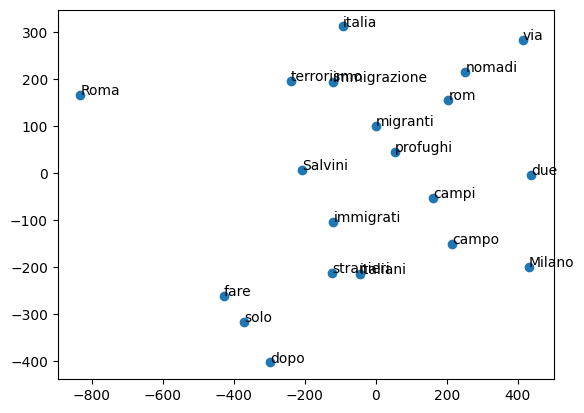

In [9]:

fig, ax = plt.subplots()
ax.scatter(reduced_embs[:,0], reduced_embs[:,1])
for i, word in enumerate(top20_clean):
    ax.annotate(word, (reduced_embs[i,0]+0.5, reduced_embs[i, 1]+0.5))

# Text normalization
[Preprocessing functions by the ItaliaNLP lab](http://www.italianlp.it/we-distributed/norm_script.py)


In [10]:
def get_digits(text):
    try:
      val = int(text)
    except:
      text = re.sub(r'\d', '@Dg', text)
      return text
    if val >= 0 and val < 2100:
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val)))

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = "___URL___" #word = unicode("___URL___") → obsolete
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

In [11]:
#import the docs → pickle file by Giulia
'''
Dict of dicts → Save each document in a dictionary:
id document id: string
raw_text document text as is (no processing): string
hs: int
stereotype: int
proc_text document text processed by Stanza Pipeline: stanza Document
'''
results_path = "../results"
pickle_file = "stanza_proc_train.pkl"

with open(os.path.join(results_path, pickle_file), 'rb') as infile:
    loaded_docs = pickle.load(infile)

In [12]:
#loaded_docs[0]['proc_text'].to_dict()[0][16]['id']
#isinstance(loaded_docs[0]['proc_text'].to_dict()[0][15]['id'], tuple)
len(loaded_docs[0]['proc_text'].to_dict()[0][15]['id'])

2

In [13]:
isinstance(loaded_docs[0]['proc_text'].to_dict()[0][19]['id'], int)

True

In [14]:
loaded_docs[0]['proc_text'].sentences[0].tokens[15]

[
  {
    "id": [
      16,
      17
    ],
    "text": "renderle",
    "start_char": 79,
    "end_char": 87
  },
  {
    "id": 16,
    "text": "render",
    "lemma": "rendere",
    "upos": "VERB",
    "xpos": "V",
    "feats": "VerbForm=Inf",
    "head": 7,
    "deprel": "conj",
    "start_char": 79,
    "end_char": 85
  },
  {
    "id": 17,
    "text": "le",
    "lemma": "le",
    "upos": "PRON",
    "xpos": "PC",
    "feats": "Clitic=Yes|Gender=Fem|Number=Plur|Person=3|PronType=Prs",
    "head": 16,
    "deprel": "obj",
    "start_char": 85,
    "end_char": 87
  }
]

In [15]:
loaded_docs[0]['proc_text'].sentences[0].tokens[15].words[1]

{
  "id": 17,
  "text": "le",
  "lemma": "le",
  "upos": "PRON",
  "xpos": "PC",
  "feats": "Clitic=Yes|Gender=Fem|Number=Plur|Person=3|PronType=Prs",
  "head": 16,
  "deprel": "obj",
  "start_char": 85,
  "end_char": 87
}

In [16]:
#Longer but more readable

"""
def get_tokens_from_tweet(doc):
    document_tokens = []
    for token in doc['proc_text'].iter_tokens():  #Prendi stanza doc dei tweet → tokenizzato, itera sui token
        if isinstance(token.id, tuple):  # Se il token ha un ID composto (clitico)
            word = normalize_text(token.text)
            token_data = {
                'word': word,
                'pos': token.words[0].upos #pos della parola lessicale principale
            }
            document_tokens.append(token_data)

        else:  # Token normale, l'id è un int
            word = normalize_text(token.text)
            pos = token.upos
            token_data = {
                'word': word,
                'pos': pos
            }
            document_tokens.append(token_data)
    return document_tokens
    """

"\ndef get_tokens_from_tweet(doc):\n    document_tokens = []\n    for token in doc['proc_text'].iter_tokens():  #Prendi stanza doc dei tweet → tokenizzato, itera sui token\n        if isinstance(token.id, tuple):  # Se il token ha un ID composto (clitico)\n            word = normalize_text(token.text)\n            token_data = {\n                'word': word,\n                'pos': token.words[0].upos #pos della parola lessicale principale\n            }\n            document_tokens.append(token_data)\n\n        else:  # Token normale, l'id è un int\n            word = normalize_text(token.text)\n            pos = token.upos\n            token_data = {\n                'word': word,\n                'pos': pos\n            }\n            document_tokens.append(token_data)\n    return document_tokens\n    "

In [17]:
def create_token_data(word, pos):
  """
  Helper function, builds a dictionary with the token data.
  """
  return {'word': word, 'pos': pos}

def get_tokens_from_tweet(doc):
  """
  For a doc (tweet), iterate over its tokens and creates a dict for each token,
  containing its normalized form (that matches the embeddings' normalization) and its POS.
  If the token has clitics, the POS is taken from the host (in Italian: the first word).
  """
  document_tokens = []
  for token in doc['proc_text'].iter_tokens():  #Prendi stanza doc dei tweet → tokenizzato, itera sui token
      word = normalize_text(token.text)
      token_data = create_token_data(word, token.words[0].upos if isinstance(token.id, tuple) else token.upos) #if isinstance(token.id, tuple), the token has at least a clitic
      document_tokens.append(token_data)
  return document_tokens

In [18]:
all_documents = []
for doc in loaded_docs: #itera sui tweet
  document_tokens = get_tokens_from_tweet(doc)
  all_documents.append(document_tokens)

In [19]:
all_documents[2589]#[1]['word']

[{'word': 'Pontina', 'pos': 'PROPN'},
 {'word': ',', 'pos': 'PUNCT'},
 {'word': 'ora', 'pos': 'ADV'},
 {'word': 'i', 'pos': 'DET'},
 {'word': 'rom', 'pos': 'NOUN'},
 {'word': 'assaltano', 'pos': 'VERB'},
 {'word': 'anche', 'pos': 'ADV'},
 {'word': 'gli', 'pos': 'DET'},
 {'word': 'automobilisti', 'pos': 'NOUN'}]

#Exploring the embedding representation of the tweets

In [20]:
def vocabulary_tweets(all_documents):
  vocabulary = set()
  for tweet in all_documents:
    for token in tweet:
      vocabulary.add(token['word'])
  return vocabulary

In [21]:
tweets_vocab = vocabulary_tweets(all_documents)
embs_vocab = set(embeddings.keys())

missing_words = tweets_vocab - embs_vocab

In [22]:
coverage = (len(tweets_vocab - missing_words) / len(tweets_vocab)) * 100
print(f"Numero di parole OOV: {len(missing_words)} su {len(tweets_vocab)}.")
print(f"Copertura embedding: {coverage:.2f}%.")

Numero di parole OOV: 2703 su 22709.
Copertura embedding: 88.10%.


In [23]:
missing_words_freq = Counter(missing_words)
missing_words_freq

Counter({'stranieri@dg@dg': 1,
         'Bep…': 1,
         'Svisceratamente': 1,
         'itayper': 1,
         'po!': 1,
         'esiamonoi': 1,
         'Lauraboldrini': 1,
         'Pd:': 1,
         'Clandestini,': 1,
         'eritreademocratica': 1,
         '😳poi': 1,
         'Corano.no': 1,
         'Marzuk': 1,
         'Coffeebreakla@dg': 1,
         'Pd👀': 1,
         'Na…': 1,
         'orgaglioso': 1,
         'Braccialettoelettronico': 1,
         'Stop!dalleparoleaifatti': 1,
         '&lt;': 1,
         'figli:@dgpiano': 1,
         'Gujana': 1,
         'espelleteli': 1,
         'A…': 1,
         'Quintacolonnama': 1,
         'poi…': 1,
         'islam🕌': 1,
         'protessi': 1,
         'Stopimmigration': 1,
         'Lardosa': 1,
         'Pd!movimentonesti': 1,
         'Guadeloupean': 1,
         'delinquere•truffa': 1,
         'Buonnatale@dg@dg@dg@dg': 1,
         '?e': 1,
         'Natale…': 1,
         'italiani!': 1,
         'Pietà!': 1,
         'al

All OOV words only appear once. At closer inspection, most of them seem to be caused by hashtags (characterized by the lack of seaparation between the words, failed tokenization (especially of repeated emojiis and of punctuation) and typos.

# Feature Extraction


## Averaging word embeddings
We'll represent each tweet by aggreagating the embeddings of its tokens.


1.   Doc = mean of all its token embeddings
2.   Doc = mean of its "lessically full" token embeddings
3.   Doc = concatenation of the 3 mean vectors of its nouns, verbs and adjectives.



In [24]:
def compute_embeddings_mean(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0) #axis=0→media per righe
    mean_array = np.divide(sum_array, len(document_embeddings))
    return mean_array

In [25]:
def compute_all_embeddings_mean(document_tokens):
    """
    1. Doc = mean of all its token embeddings
    """
    document_embeddings = []

    for token in document_tokens:
        word = token['word']
        if word in embeddings:
            document_embeddings.append(embeddings[word])

    if len(document_embeddings) == 0: #if no words are in the embeddings dict
        mean_document_embeddings = np.zeros(128) #128-dimensional vect with only 0s
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

In [26]:
def compute_filtered_embeddings_mean(document_tokens):
    """
    2. Doc = mean of its "lessically full" token embeddings
    """
    document_embeddings = []

    for token in document_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB']:
            document_embeddings.append(embeddings[word])

    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(128)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

In [27]:
def compute_filtered_embeddings_sep_means(document_tokens):
    """
    3. Doc = concatenation of the 3 mean vectors of its nouns, verbs and adjectives.
    """
    pos_groups = {'ADJ': [], 'NOUN': [], 'VERB': []}

    # Collect embeddings by POS group
    for token in document_tokens:
        word, pos = token['word'], token['pos']
        if word in embeddings and pos in pos_groups:
            pos_groups[pos].append(embeddings[word])

    # Compute mean embeddings or default to zeros
    mean_embeddings = {
        pos: compute_embeddings_mean(pos_groups[pos]) if pos_groups[pos] else np.zeros(128)
        for pos in pos_groups
    }

    # Concatenate all means into a single vector
    mean_document_embeddings = np.concatenate(
        [mean_embeddings['ADJ'], mean_embeddings['NOUN'], mean_embeddings['VERB']], axis=None
    )
    return mean_document_embeddings

## Weighted embeddings
Use TF-IDF to weigh embeddings

# Build feature matrix

In [28]:
def extract_features(documents):
    dataset_features = []
    for document_tokens in documents:
        # document_embeddings = compute_all_embeddings_mean(document_tokens)
        document_embeddings = compute_filtered_embeddings_mean(document_tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document_tokens)
        dataset_features.append(document_embeddings)
    return dataset_features

In [29]:
all_features = extract_features(all_documents)

In [30]:
len(all_features), len(all_features[0])
#(n. tweets, embeddings' dimensions)

(6837, 128)

In [31]:
def create_label_list(loaded_docs):
  labels = []
  for doc in loaded_docs:
    labels.append(doc['hs'])
  return labels

all_labels = create_label_list(loaded_docs)

# Run experiment: SVM

## Normalization

## Classification